In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sympy import Symbol
import centrex_TlF as centrex
import matplotlib.pyplot as plt

import sys
sys.path.append("../..")
from utils.plot_utils import set_fontsize

In [113]:
nprocs = 6

# Γ
Γ = 1.56e6*2*np.pi

# TlF temperature
T = 6.3

# Define all involved states

# ground state J levels
ground_Js = [0,1,2]

# excited state quantum numbers
excited_Js = [1]
excited_F1s = [3/2]
excited_Fs = [1]
excited_Ps = [-1]

# Settings for transitions

# min and max J level to look for mixing in the B state
excited_Jmin = 1
excited_Jmax = 2


# main laser transition P(2) F'=1 F1'=3/2

ground_main_approx = 1*centrex.CoupledBasisState(J=2,F1=3/2,F=2,mF=0,I1=1/2,I2=1/2,
                                                 electronic_state='X', P = (-1)**2, Omega = 0)
excited_main_approx = 1*centrex.CoupledBasisState(J=1,F1=3/2,F=1,mF=0,I1=1/2,I2=1/2, 
                                                  electronic_state='B', P = -1, Omega = 1)
# ground laser J
laser_J = [2]

transitions = [{'ground main approx': ground_main_approx, 
                'excited main approx': excited_main_approx,
                'ground states approx': 1*centrex.states.generate_coupled_states_ground(laser_J),
                'excited states approx': 1*centrex.states.generate_coupled_states_excited(
                                                excited_Js, excited_Fs, excited_F1s, excited_Ps),
                'main polarization': np.array([0,0,1]),
                'polarizations': [np.array([0,0,1]), np.array([1,0,0])],
                'polarization symbols': [Symbol("Plz"), Symbol("Plx")],
                'Ω symbol': Symbol('Ωl', complex = True),
                'Δ symbol': Symbol('δl'),
                'description': "P2 F1 laser transition"
               }]
               
# make sure that subsequent transitions don't have their excited state be the ground state of another transition
transitions.append(
    {
        'ground main approx': 1*centrex.CoupledBasisState(J=2,F1=5/2,F=2,mF=0,I1=1/2,I2=1/2, electronic_state='X', P = (-1)**2, Omega = 0),
        'excited main approx': 1*centrex.CoupledBasisState(J=1,F1=3/2,F=1,mF=0,I1=1/2,I2=1/2,electronic_state='X', P = (-1)**1, Omega = 0),
        'ground states approx': 1*centrex.states.generate_coupled_states_ground([2]),
        'excited states approx': 1*centrex.states.generate_coupled_states_ground([1]),
        'main polarization': np.array([0,0,1]),
        'polarizations': [np.array([0,0,1]), np.array([0,1,0])],
        'polarization symbols': [Symbol("Pμ12z"), Symbol("Pμ12y")],
        'Ω symbol': Symbol('Ωμ12', complex = True),
        'Δ symbol': Symbol('δμ12'),
        'description': "J12 microwave transition"
    }
)

# sanity check to ensure no ground states for one transition are an
# excited state for another transition
centrex.couplings.utils.check_transitions(transitions)

In [46]:
# specify states to combine into a single level 
# e.g. only decay to these states and not interested in population distribution there
slice_compact = None

### Specifying parameters and the ode function preamble
Allows for setting parameters to be time dependent (e.g. sin(t), cos(t))

In [47]:
# order of parameters in p
parameters = ['Ωl', 'δl', 'ωlp', 'ϕlp', 'Ωμ12', 'δμ12', 'ωμ12p', 'ϕμ12p']

In [48]:
preamble = """function Lindblad_rhs!(du, ρ, p, t)
\t@inbounds begin
\t\tΩl = p[1]
\t\tδl = p[2]
\t\tωlp = p[3]
\t\tϕlp = p[4]
\t\tΩlᶜ = conj(Ωl)

\t\tPl = sin(ωlp*t + ϕlp)
\t\tPlx = (1-Pl)/2
\t\tPlz = (1+Pl)/2

\t\tΩμ12 = p[5]
\t\tδμ12 = p[6]
\t\tωμ12p = p[7]
\t\tϕμ12p = p[8]
\t\tΩμ12ᶜ = conj(Ωμ12)

\t\tPμ12 = sin(ωμ12p*t + ϕμ12p)
\t\tPμ12y = (1-Pμ12)/2
\t\tPμ12z = (1+Pμ12)/2

"""

In [49]:
odepars = centrex.lindblad.odeParameters(parameters)
odepars.Ωl = Γ
odepars.ωlp = Γ
odepars.Ωμ12 = Γ
odepars.ωμ12p = Γ
odepars.ϕμ12p = np.pi/2
odepars

odeParameters(Ωl: 9.80e+06, δl: 0.00e+00, ωlp: 9.80e+06, ϕlp: 0.00e+00, Ωμ12: 9.80e+06, δμ12: 0.00e+00, ωμ12p: 9.80e+06, ϕμ12p: 0.00e+00)

## Start calculations for Hamiltonian and transitions

In [50]:
%%time 
ground_states_approx = centrex.states.generate_coupled_states_ground(ground_Js)
excited_states_approx = centrex.states.generate_coupled_states_excited(excited_Js, excited_Fs, 
                                                                       excited_F1s, excited_Ps)

ground_states, excited_states, QN, H_int, V_ref_int = centrex.hamiltonian.generate_total_reduced_hamiltonian(
                                            ground_states_approx, excited_states_approx)

Wall time: 7.09 s


In [51]:
%%time
couplings = []
for transition in transitions:
    coupling = centrex.couplings.generate_coupling_field(
                                        transition['ground main approx'],
                                        transition['excited main approx'],
                                        transition['ground states approx'],
                                        transition['excited states approx'],
                                        H_int, QN, V_ref_int, 
                                        pol_main = transition['main polarization'],
                                        pol_vec = transition['polarizations'],
                                        nprocs = nprocs)
    couplings.append(coupling)

Wall time: 52.8 s


In [52]:
%%time
H_symbolic = centrex.lindblad.generate_total_symbolic_hamiltonian(QN, H_int, couplings, transitions, 
                                                                slice_compact = slice_compact)

Wall time: 575 ms


In [53]:
%%time
C_array = centrex.couplings.collapse_matrices(QN, ground_states, excited_states, gamma = Γ, 
                                            slice_compact = slice_compact)
system = centrex.lindblad.generate_system_of_equations_symbolic(H_symbolic, C_array, progress = False, fast = True)

Wall time: 26.9 s


In [54]:
%%time
# convert matrix to system of equations code
code_lines = centrex.lindblad.system_of_equations_to_lines(system, nprocs = nprocs)

Wall time: 32.9 s


# Solving ODE system with Julia
Need to install Julia and add the following packages to Julia:  
* [DifferentialEquations](https://diffeq.sciml.ai/stable/)
* [Trapz](https://github.com/francescoalemanno/Trapz.jl)

And install [PyJulia](https://pyjulia.readthedocs.io/en/latest/index.html) for python.  

In [56]:
# import julia
# julia.install()

In [57]:
from julia import Main
centrex.lindblad.initialize_julia(nprocs = nprocs)

_ = centrex.lindblad.generate_ode_fun_julia(preamble, code_lines)

# generate initial conditions
ρ_ini = centrex.utils.generate_thermal_J(ground_Js, len(excited_states), T, normalized = True)
centrex.lindblad.setup_variables_julia(Γ, ρ_ini)
odepars.generate_p_julia()

Initialized Julia with 6 processes


### Setting up the ODE problem to solve
`tmp = 0` is just to prevent `Main.eval` from outputting the problem in the notebook.  
The ODEProblem takes a function to solve (`Lindblad_rhs!` in this case), initial conditions `ρ_ini`, a timespan `tspan` an additional arguments for the ODE function, denoted here by `p` 

In [64]:
Main.eval("""
tspan = (0.0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ,tspan,p)
""");

In [114]:
%%time
Main.eval("""
@time sol = solve(prob, Tsit5(), abstol = 1e-7, reltol = 1e-4, progress = false);
tmp = 0
""");

Wall time: 1.99 s


0

In [66]:
ut = np.array(Main.eval("sol[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("sol.t")

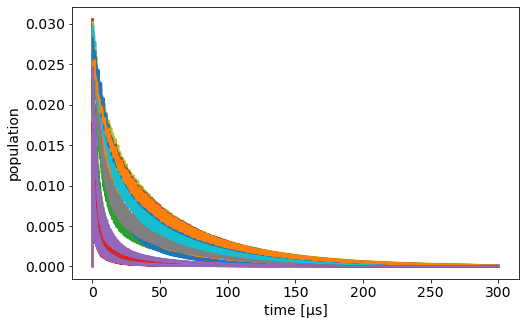

In [67]:
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    ls = '-'
    if idx in range(4,len(pop_results)):
        s = QN[idx].find_largest_component()
        label = f'{s.electronic_state}, J={s.J}, F={s.F:.0f}, F1={s.F1}, mF={s.mF:+.0f}'
        ax.plot(t_array*1e6, pop, lw = 2, label = label, ls = ls)
#         ax.plot(t_array, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$", ls = ls)

ax.set_xlabel('time [μs]')
ax.set_ylabel('population')
# ax.legend(fontsize = 14)
set_fontsize(ax, 14)

## Scan Rabi Rate

In [199]:
odepars.Ωl = Γ
odepars.Ωμ12 = Γ
odepars

odeParameters(Ωl: 9.80e+06, δl: 0.00e+00, ωlp: 9.80e+06, ϕlp: 0.00e+00, Ωμ12: 9.80e+06, δμ12: 0.00e+00, ωμ12p: 9.80e+06, ϕμ12p: 0.00e+00)

In [200]:
odepars.generate_p_julia()
Main.eval("""
tspan = (0.0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ,tspan,p)
""");

In [208]:
# generate the prob_func to remake the problem for each iteration
centrex.lindblad.setup_parameter_scan_1D(odepars, ['Ωl', 'Ωμ12'], np.linspace(0,1*Γ,101))

In [209]:
# generate the output_func to transform the ode slution after integration
centrex.lindblad.setup_ratio_calculation([[1],[2,3,4]])

In [210]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
""");

In [211]:
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(); trajectories = size(params)[1],
            abstol = 1e-7, reltol = 1e-4, save_everystep = false)
sim.elapsedTime
""")

17.1982716

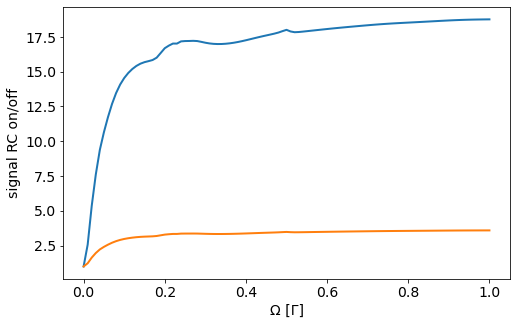

In [212]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(Main.params/Main.Γ, np.asarray(Main.sim)[0], lw = 2)
ax.plot(Main.params/Main.Γ, np.asarray(Main.sim)[1], lw = 2)

ax.set_xlabel('Ω [Γ]')
ax.set_ylabel('signal RC on/off')

set_fontsize(ax, 14)

In [207]:
pF0 = np.diag(ρ_ini)[0].real
pF1 = np.diag(ρ_ini)[1:4].real.sum()

rJ12_F0 = 0.337/(0.147+0.337) * np.diag(ρ_ini)[4:].sum().real
rJ12_F1 = 0.147/0.337 * rJ12_F0

gF0 = (pF0 + rJ12_F0)/pF0
gF1 = (pF1 + rJ12_F1)/pF1

print(f"max gain in J = 0, F = 0 : {(gF0):.2f}")
print(f"max gain in J = 0, F = 1 : {(gF1):.2f}")

max gain in J = 0, F = 0 : 18.82
max gain in J = 0, F = 1 : 3.59


## Scan Polarization switching frequency

In [213]:
odepars.Ωl = 0.2*Γ
odepars.Ωμ12 = 0.2*Γ
odepars

In [214]:
odepars.generate_p_julia()
Main.eval("""
tspan = (0.0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ,tspan,p)
""");

In [215]:
# generate the prob_func to remake the problem for each iteration
centrex.lindblad.setup_parameter_scan_1D(odepars, ['ωlp', 'ωμ12p'], np.linspace(0,1*Γ,101))

In [216]:
# generate the output_func to transform the ode slution after integration
centrex.lindblad.setup_ratio_calculation([[1],[2,3,4]])

In [220]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
""");

In [221]:
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(); trajectories = size(params)[1],
            abstol = 1e-7, reltol = 1e-4, save_everystep = false)
sim.elapsedTime
""")

8.0776522

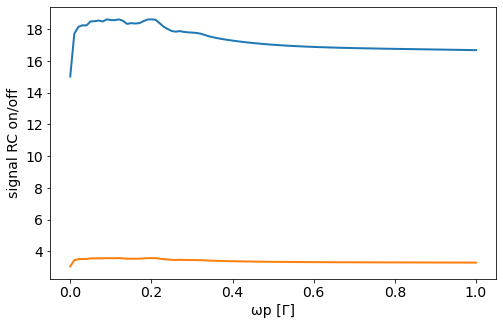

In [222]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(Main.params/Main.Γ, np.asarray(Main.sim)[0], lw = 2)
ax.plot(Main.params/Main.Γ, np.asarray(Main.sim)[1], lw = 2)

ax.set_xlabel('ωp [Γ]')
ax.set_ylabel('signal RC on/off')

set_fontsize(ax, 14)

In [224]:
np.max(np.array(Main.sim)[0])

18.628145636624893

In [223]:
pF0 = np.diag(ρ_ini)[0].real
pF1 = np.diag(ρ_ini)[1:4].real.sum()

rJ12_F0 = 0.337/(0.147+0.337) * np.diag(ρ_ini)[4:].sum().real
rJ12_F1 = 0.147/0.337 * rJ12_F0

gF0 = (pF0 + rJ12_F0)/pF0
gF1 = (pF1 + rJ12_F1)/pF1

print(f"max gain in J = 0, F = 0 : {(gF0):.2f}")
print(f"max gain in J = 0, F = 1 : {(gF1):.2f}")

max gain in J = 0, F = 0 : 18.82
max gain in J = 0, F = 1 : 3.59


## Scan only polarization switching frequency microwaves

In [225]:
odepars.Ωl = 0.2*Γ
odepars.Ωμ12 = 0.8*Γ
odepars.ωlp = 0
odepars

odeParameters(Ωl: 1.96e+06, δl: 0.00e+00, ωlp: 0.00e+00, ϕlp: 0.00e+00, Ωμ12: 7.84e+06, δμ12: 0.00e+00, ωμ12p: 9.80e+06, ϕμ12p: 0.00e+00)

In [226]:
odepars.generate_p_julia()
Main.eval("""
tspan = (0.0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ,tspan,p)
""");

In [227]:
# generate the prob_func to remake the problem for each iteration
centrex.lindblad.setup_parameter_scan_1D(odepars, 'ωμ12p', np.linspace(0,1*Γ,101))

In [228]:
# generate the output_func to transform the ode slution after integration
centrex.lindblad.setup_ratio_calculation([[1],[2,3,4]])

In [229]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
""");

In [230]:
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(); trajectories = size(params)[1],
            abstol = 1e-7, reltol = 1e-4, save_everystep = false)
sim.elapsedTime
""")

12.6962729

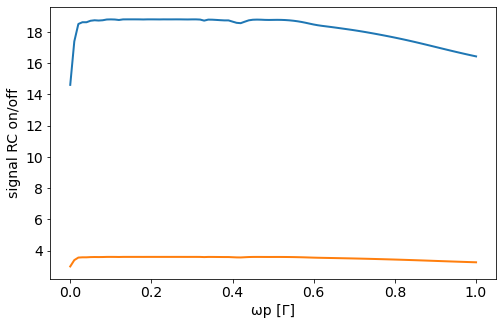

In [231]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(Main.params/Main.Γ, np.asarray(Main.sim)[0], lw = 2)
ax.plot(Main.params/Main.Γ, np.asarray(Main.sim)[1], lw = 2)

ax.set_xlabel('ωp [Γ]')
ax.set_ylabel('signal RC on/off')

set_fontsize(ax, 14)

In [232]:
np.max(np.array(Main.sim)[0])

18.797761549587065

In [233]:
pF0 = np.diag(ρ_ini)[0].real
pF1 = np.diag(ρ_ini)[1:4].real.sum()

rJ12_F0 = 0.337/(0.147+0.337) * np.diag(ρ_ini)[4:].sum().real
rJ12_F1 = 0.147/0.337 * rJ12_F0

gF0 = (pF0 + rJ12_F0)/pF0
gF1 = (pF1 + rJ12_F1)/pF1

print(f"max gain in J = 0, F = 0 : {(gF0):.2f}")
print(f"max gain in J = 0, F = 1 : {(gF1):.2f}")

max gain in J = 0, F = 0 : 18.82
max gain in J = 0, F = 1 : 3.59
